In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import os
import cv2
from PIL import Image


from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [3]:
training_path = './Training/'
testing_path = './Testing'

os.listdir(testing_path)


['glioma', 'meningioma', 'notumor', 'pituitary']

In [4]:
from torchvision.io import read_image

class TumorDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.dataset_dir = img_dir
        self.category_dir = os.listdir(img_dir)
        self.data = self.load_data()
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def load_data(self):
        data = []
        for i , category in enumerate(self.category_dir):
            category_path = os.path.join(self.dataset_dir , category)
            for file_name in os.listdir(category_path):
                img_path = os.path.join(category_path , file_name)
                data.append([img_path , i])
        return data

    def __getitem__(self, idx):
        img_path , label = self.data[idx]
#         print(img_path)
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(label)
        if self.transform:
            tansformed_image = self.transform(image)
            
        return tansformed_image.to(device) , label.to(device)



In [5]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.1858, 0.1858, 0.1859), (0.1841, 0.1841, 0.1841))
])

In [6]:
train_data = TumorDataset(training_path,  transform)
test_data = TumorDataset(testing_path, transform )

In [7]:
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

In [8]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

4569
1143
1311


In [9]:
train_loader = DataLoader(dataset = train_data, batch_size = 16, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset = val_data, batch_size = 16, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset = test_data, batch_size = 16, shuffle=True, num_workers=0)

In [ ]:
# https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949/2

mean = 0.
std = 0.
for images, _ in val_loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    
for images, _ in train_loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    
for images, _ in test_loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(train_loader.dataset + val_loader.dataset + test_loader.dataset)
std /= len(train_loader.dataset + val_loader.dataset + test_loader.dataset)


print(mean)
print(std)

C:\Users\julia\AppData\Local\Temp\ipykernel_9828\3077884524.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3618.)
  plt.imshow(img.T, cmap="gray")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([16, 3, 300, 300])
Labels batch shape: torch.Size([16])


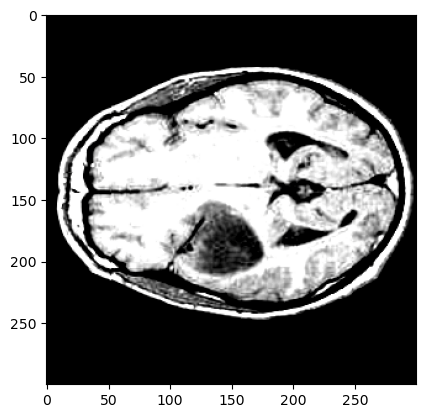

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 2


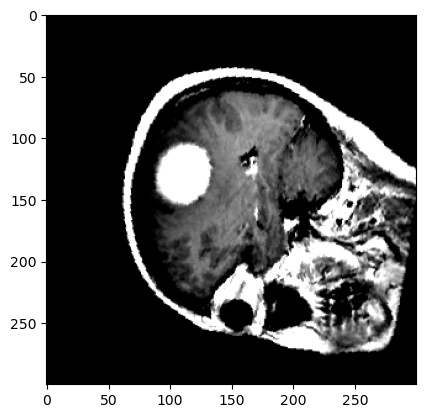

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 1


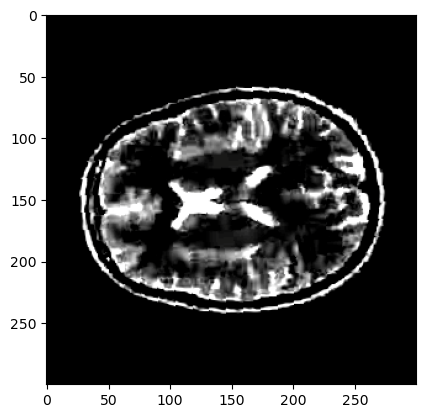

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 2


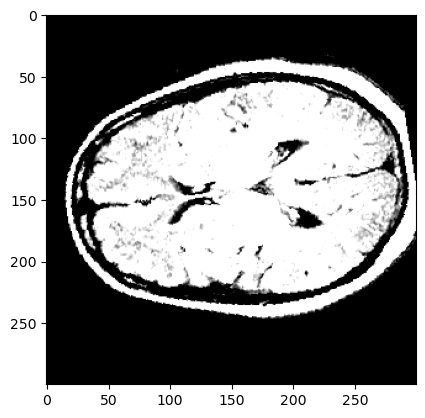

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 2


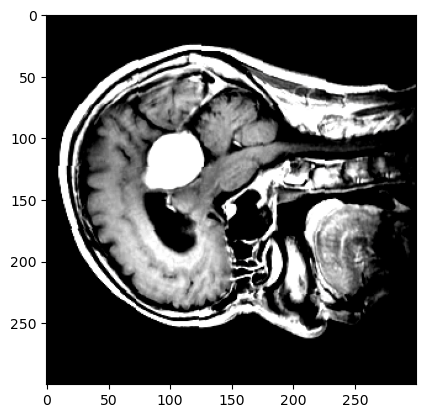

Label: 1


In [10]:
trainimages, trainlabels = next(iter(train_loader))

print(f"Feature batch shape: {trainimages.size()}")
print(f"Labels batch shape: {trainlabels.size()}")
for i in range(5):
    img = trainimages[i].squeeze().cpu()
    label = trainlabels[i]
    plt.imshow(img.T, cmap="gray")
    plt.show()
    print(f"Label: {label}")

In [11]:
class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 36, kernel_size=3)
        self.fc1 = nn.Linear(191844, 1024)
        self.fc2 = nn.Linear(1024, 4)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.shape[0],-1)
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [ ]:
# class CNN(nn.Module): 
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.features = nn.Sequential(
#         nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, padding = 1),
#         nn.ReLU(inplace=True),
#         nn.MaxPool2d(kernel_size=2, stride=2),
#         nn.Conv2d(12, 24, kernel_size=3, padding = 1),
#         nn.ReLU(inplace=True),
#         nn.MaxPool2d(kernel_size=2, stride=2))        
        
#         self.classifier = nn.Sequential(
#         nn.Linear(2160000, 1024),
#         nn.Linear(1024, 4))

#     def forward(self, x):
#         x = self.features(x)
#         x = x.flatten()
#         x = self.classifier(x)
#         print(x.shape)
#         return x

In [12]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [13]:
%%time
# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(1, 20 + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-single-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in val_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 1.449473 	Validation Loss: 0.427850
Epoch: 2 	Training Loss: 0.416090 	Validation Loss: 0.354707


KeyboardInterrupt: 

In [17]:
# test-the-model
model.eval()  # it-disables-dropout
predictions = []
truth = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
#         predictions.append(predicted.cpu())
#         truth.append(labels.cpu())
        correct += (predicted == labels).sum().item()
     
    
print('Test Accuracy of the model: {} %'.format(100 * correct / total))

Test Accuracy of the model: 80.32036613272311 %


In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(truth, predictions)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

C:\Users\julia\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\julia\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have t

ValueError: unknown is not supported

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

# TODO:

- Validation and Graphs, confusion matrix
- Architecture changes
- Hyperparameter tuning
- Backbone
- Transformations parameters, normalize images
